In [1]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=c56a9727c7bfca7cdfdd114ce9b27b4b75f37c3959791dc62ec766dc3b154f00
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession

# Initialiser la session Spark
spark = SparkSession.builder.appName("BVB Analysis").getOrCreate()

# Lire les fichiers CSV
matches_df = spark.read.csv("/content/drive/MyDrive/football_projects/optimisation des stratégies de jeu/matches_bvb_2024.csv", header=True, inferSchema=True)
player_stats_df = spark.read.csv("/content/drive/MyDrive/football_projects/optimisation des stratégies de jeu/player_stats_bvb_2024.csv", header=True, inferSchema=True)
shots_df = spark.read.csv("/content/drive/MyDrive/football_projects/optimisation des stratégies de jeu/shots_bvb_2024.csv", header=True, inferSchema=True)


In [5]:
# Créer des vues temporaires pour SQL

matches_df.createOrReplaceTempView("matches")
player_stats_df.createOrReplaceTempView("player_stats")
shots_df.createOrReplaceTempView("shots")


 Requêtes SQL pour analyser les données

In [14]:
# Extended SQL query to get goals scored, goals conceded, shots, and shots on target for Borussia Dortmund
query = """
SELECT
    SUM(CASE WHEN team_h = 'Borussia Dortmund' THEN h_goals ELSE 0 END) AS home_goals_scored,
    SUM(CASE WHEN team_a = 'Borussia Dortmund' THEN a_goals ELSE 0 END) AS away_goals_scored,
    SUM(CASE WHEN team_h = 'Borussia Dortmund' THEN a_goals ELSE 0 END) AS home_goals_conceded,
    SUM(CASE WHEN team_a = 'Borussia Dortmund' THEN h_goals ELSE 0 END) AS away_goals_conceded,
    SUM(CASE WHEN team_h = 'Borussia Dortmund' THEN h_shot ELSE 0 END) AS home_shots,
    SUM(CASE WHEN team_a = 'Borussia Dortmund' THEN a_shot ELSE 0 END) AS away_shots,
    SUM(CASE WHEN team_h = 'Borussia Dortmund' THEN h_shotOnTarget ELSE 0 END) AS home_shots_on_target,
    SUM(CASE WHEN team_a = 'Borussia Dortmund' THEN a_shotOnTarget ELSE 0 END) AS away_shots_on_target
FROM matches
WHERE team_h = 'Borussia Dortmund' OR team_a = 'Borussia Dortmund'
"""

bvb_stats = spark.sql(query)
bvb_stats.show()



+-----------------+-----------------+-------------------+-------------------+----------+----------+--------------------+--------------------+
|home_goals_scored|away_goals_scored|home_goals_conceded|away_goals_conceded|home_shots|away_shots|home_shots_on_target|away_shots_on_target|
+-----------------+-----------------+-------------------+-------------------+----------+----------+--------------------+--------------------+
|               10|                2|                  4|                  7|        56|        24|                  19|                  11|
+-----------------+-----------------+-------------------+-------------------+----------+----------+--------------------+--------------------+



In [13]:
# Count goals conceded by Borussia Dortmund at home and away
query = """
SELECT
    SUM(CASE WHEN team_h = 'Borussia Dortmund' THEN a_goals ELSE 0 END) AS home_goals_conceded,
    SUM(CASE WHEN team_a = 'Borussia Dortmund' THEN h_goals ELSE 0 END) AS away_goals_conceded
FROM matches
WHERE team_h = 'Borussia Dortmund' OR team_a = 'Borussia Dortmund'
"""

bvb_goals_conceded = spark.sql(query)
bvb_goals_conceded.show()


+-------------------+-------------------+
|home_goals_conceded|away_goals_conceded|
+-------------------+-------------------+
|                  4|                  7|
+-------------------+-------------------+



In [17]:
# Extended SQL query to get average xG for Borussia Dortmund and oponent at home and away
query = """
SELECT
    ROUND(AVG(CASE WHEN team_h = 'Borussia Dortmund' THEN h_xg ELSE NULL END), 2) AS avg_home_xg_bvb,
    ROUND(AVG(CASE WHEN team_a = 'Borussia Dortmund' THEN a_xg ELSE NULL END), 2) AS avg_away_xg_bvb,
    ROUND(AVG(CASE WHEN team_h = 'Borussia Dortmund' THEN a_xg ELSE NULL END), 2) AS avg_home_xg_openent,
    ROUND(AVG(CASE WHEN team_a = 'Borussia Dortmund' THEN h_xg ELSE NULL END), 2) AS avg_away_xg_oponent
FROM matches
WHERE team_h = 'Borussia Dortmund' OR team_a = 'Borussia Dortmund'
"""

bvb_avg_xg = spark.sql(query)
bvb_avg_xg.show()


+---------------+---------------+-------------------+-------------------+
|avg_home_xg_bvb|avg_away_xg_bvb|avg_home_xg_openent|avg_away_xg_oponent|
+---------------+---------------+-------------------+-------------------+
|           2.98|           0.76|               1.27|               1.79|
+---------------+---------------+-------------------+-------------------+



h_ppda (Home PPDA): Passes allowed per defensive action by the home team. This metric measures how aggressively a team presses their opponent when they do not have the ball. A lower PPDA indicates more pressing.


a_ppda (Away PPDA): Passes allowed per defensive action by the away team. Similar to h_ppda but for the away team.


h_deep (Home Deep Completions): The number of passes completed by the home team within 20 meters of the opponent's goal.


a_deep (Away Deep Completions): The number of passes completed by the away team within 20 meters of the opponent's goal.

In [19]:
# Extended SQL query to get average PPDA and deep completions for Borussia Dortmund at home and away
query = """
SELECT
    ROUND(AVG(CASE WHEN team_h = 'Borussia Dortmund' THEN h_ppda ELSE NULL END), 2) AS avg_home_ppda_bvb,
    ROUND(AVG(CASE WHEN team_a = 'Borussia Dortmund' THEN a_ppda ELSE NULL END), 2) AS avg_away_ppda_bvb,
    ROUND(AVG(CASE WHEN team_h = 'Borussia Dortmund' THEN h_deep ELSE NULL END), 2) AS avg_home_deep_completions_bvb,
    ROUND(AVG(CASE WHEN team_a = 'Borussia Dortmund' THEN a_deep ELSE NULL END), 2) AS avg_away_deep_completions_bvb
FROM matches
WHERE team_h = 'Borussia Dortmund' OR team_a = 'Borussia Dortmund'
"""

bvb_metrics = spark.sql(query)
bvb_metrics.show()

+-----------------+-----------------+-----------------------------+-----------------------------+
|avg_home_ppda_bvb|avg_away_ppda_bvb|avg_home_deep_completions_bvb|avg_away_deep_completions_bvb|
+-----------------+-----------------+-----------------------------+-----------------------------+
|             8.44|            12.15|                        10.67|                         4.67|
+-----------------+-----------------+-----------------------------+-----------------------------+



Top Players by Goals

In [21]:
query_top_goals = """
SELECT
    player,
    SUM(goals) AS total_goals,
    SUM(assists) AS total_assists,
    ROUND(AVG(xG), 2) AS AVG_xG,
    ROUND(AVG(xA), 2) AS AVG_xA
FROM player_stats
GROUP BY player
ORDER BY total_goals DESC
LIMIT 10
"""

top_players_goals = spark.sql(query_top_goals)
top_players_goals.show()


+-------------------+-----------+-------------+------+------+
|             player|total_goals|total_assists|AVG_xG|AVG_xA|
+-------------------+-----------+-------------+------+------+
|    Serhou Guirassy|          3|            0|  0.95|  0.09|
|Jamie Bynoe-Gittens|          2|            1|  0.11|  0.06|
|           Emre Can|          2|            0|  0.28|  0.02|
|      Karim Adeyemi|          2|            3|   0.2|  0.44|
|      Donyell Malen|          1|            0|  0.05|   0.0|
|     Julian Ryerson|          1|            1|  0.03|  0.09|
|       Felix Nmecha|          1|            0|  0.02|  0.03|
|    Ramy Bensebaini|          0|            1|  0.02|  0.09|
| Nico Schlotterbeck|          0|            0|  0.08|  0.01|
|     Waldemar Anton|          0|            0|  0.06|  0.01|
+-------------------+-----------+-------------+------+------+



In [29]:
# Query for top 10 players in AMC and CM positions based on key passes per match
query_top_key_passes = """
SELECT
    player,
    position,
    ROUND(SUM(key_passes) / SUM(minutes_played / 90.0), 2) AS avg_key_passes_per_90,
    SUM(key_passes) AS total_key_passes,
    ROUND(SUM(key_passes) / COUNT(match_id), 2) AS avg_key_passes_per_match


FROM player_stats
WHERE position IN ('AMC', 'MC')
GROUP BY player, position
ORDER BY avg_key_passes_per_match DESC
LIMIT 10
"""
top_players_key_passes = spark.sql(query_top_key_passes)
top_players_key_passes.show()

+---------------+--------+---------------------+----------------+------------------------+
|         player|position|avg_key_passes_per_90|total_key_passes|avg_key_passes_per_match|
+---------------+--------+---------------------+----------------+------------------------+
|    Pascal Groß|      MC|                 6.00|               6|                     6.0|
|  Julian Brandt|     AMC|                 2.40|              13|                    2.17|
|Marcel Sabitzer|     AMC|                 1.08|               1|                     1.0|
|       Emre Can|      MC|                 0.00|               0|                     0.0|
+---------------+--------+---------------------+----------------+------------------------+



In [31]:
# Query for top 10 players based on total minutes played
query_top_minutes_played = """
SELECT
    player,
    SUM(minutes_played) AS total_minutes_played,
    SUM(goals) AS total_goals,
    SUM(assists) AS total_assists
FROM player_stats
GROUP BY player
ORDER BY total_minutes_played DESC
LIMIT 10
"""
top_players_min_played = spark.sql(query_top_minutes_played)
top_players_min_played.show()

+------------------+--------------------+-----------+-------------+
|            player|total_minutes_played|total_goals|total_assists|
+------------------+--------------------+-----------+-------------+
|    Waldemar Anton|                 540|          0|            0|
|      Gregor Kobel|                 540|          0|            0|
|     Julian Brandt|                 487|          0|            3|
|    Julian Ryerson|                 484|          1|            1|
|       Pascal Groß|                 479|          0|            1|
|Nico Schlotterbeck|                 434|          0|            0|
|          Emre Can|                 366|          2|            0|
|   Serhou Guirassy|                 344|          3|            0|
|       Niklas Süle|                 333|          0|            0|
|     Karim Adeyemi|                 313|          2|            3|
+------------------+--------------------+-----------+-------------+



In [35]:
# Query for average goals per match and goals per 90 minutes
query_avg_goal_assist = """
SELECT
    player,
    SUM(goals) AS total_goals,
    COUNT(DISTINCT match_id) AS total_matches,
    SUM(assists) AS total_assists,
    ROUND((SUM(goals) / COUNT(DISTINCT match_id)), 2) AS avg_goals_per_match,
    ROUND((SUM(goals) / SUM(minutes_played) * 90), 2) AS goals_per_90_min
FROM player_stats
GROUP BY player
ORDER BY avg_goals_per_match DESC
LIMIT 6
"""
top_players_goal_assist = spark.sql(query_avg_goal_assist)
top_players_goal_assist.show()

+-------------------+-----------+-------------+-------------+-------------------+----------------+
|             player|total_goals|total_matches|total_assists|avg_goals_per_match|goals_per_90_min|
+-------------------+-----------+-------------+-------------+-------------------+----------------+
|    Serhou Guirassy|          3|            4|            0|               0.75|            0.78|
|      Karim Adeyemi|          2|            5|            3|                0.4|            0.58|
|Jamie Bynoe-Gittens|          2|            6|            1|               0.33|            0.62|
|           Emre Can|          2|            6|            0|               0.33|            0.49|
|      Donyell Malen|          1|            5|            0|                0.2|            0.48|
|     Julian Ryerson|          1|            6|            1|               0.17|            0.19|
+-------------------+-----------+-------------+-------------+-------------------+----------------+



Visualization

<ipython-input-37-740394b489d1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_players_goals, x='player', y='total_goals', palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When gr

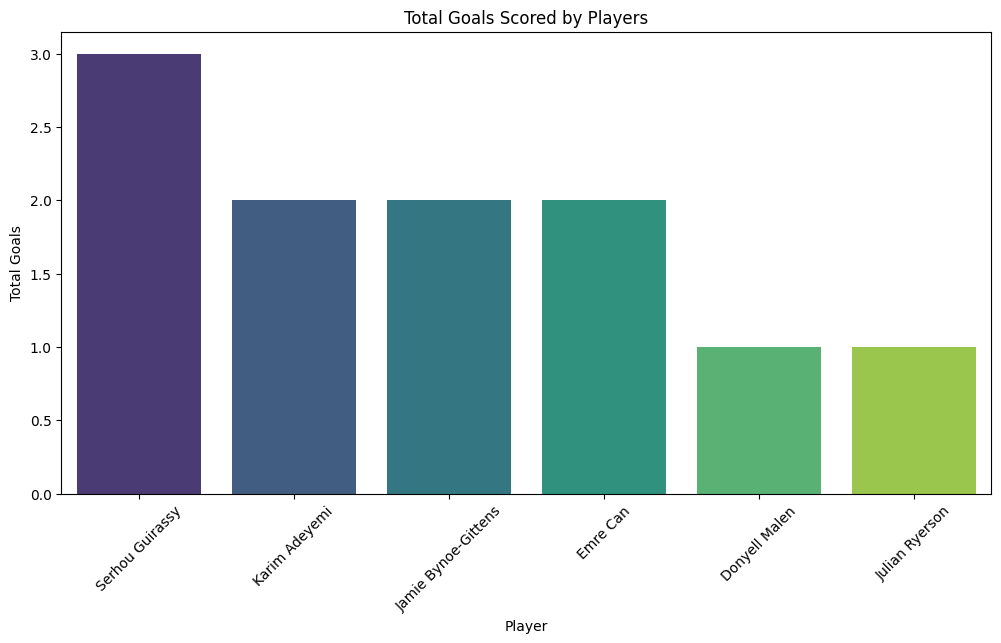

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame called `top_players_goals`
top_players_goals = top_players_goal_assist.toPandas()  # Convert to pandas DataFrame

# Bar plot for total goals scored
plt.figure(figsize=(12, 6))
sns.barplot(data=top_players_goals, x='player', y='total_goals', palette='viridis')
plt.title('Total Goals Scored by Players')
plt.xlabel('Player')
plt.ylabel('Total Goals')
plt.xticks(rotation=45)
plt.show()


<ipython-input-40-20fa0c6b70e9>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_goals_per_match, x='player', y='avg_goals_per_match', palette='coolwarm')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarn

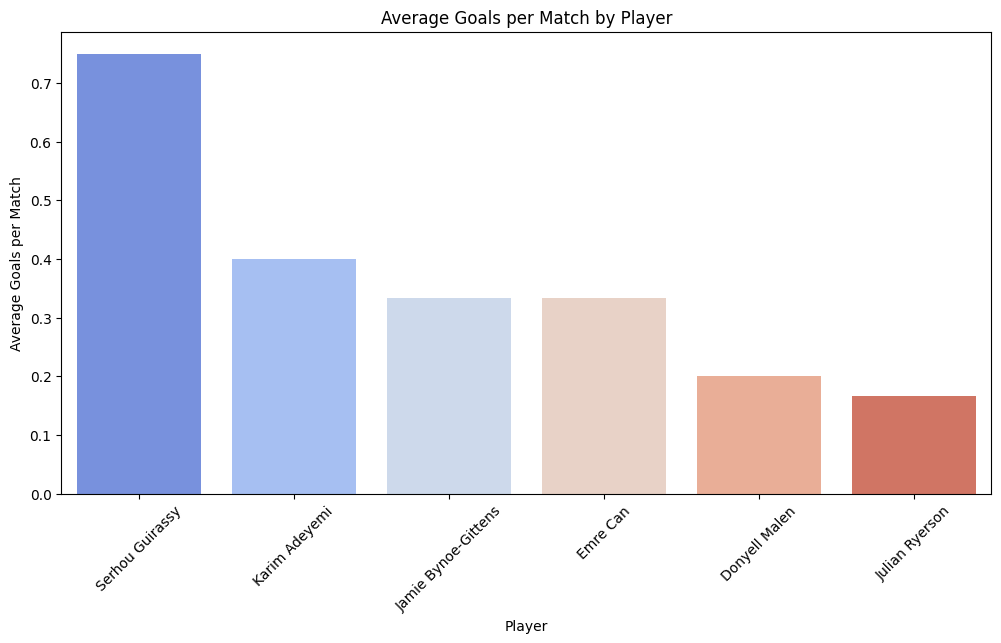

In [40]:
# Assuming you have a DataFrame called `avg_goals_per_match`
avg_goals_per_match = spark.sql("""
SELECT player, AVG(goals) AS avg_goals_per_match
FROM player_stats
GROUP BY player
ORDER BY avg_goals_per_match DESC
LIMIT 6
""").toPandas()

# Bar plot for average goals per match
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_goals_per_match, x='player', y='avg_goals_per_match', palette='coolwarm')
plt.title('Average Goals per Match by Player')
plt.xlabel('Player')
plt.ylabel('Average Goals per Match')
plt.xticks(rotation=45)
plt.show()


<ipython-input-43-94734c547c62>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xG_data, x='player', y='total_xG', palette='magma')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a 

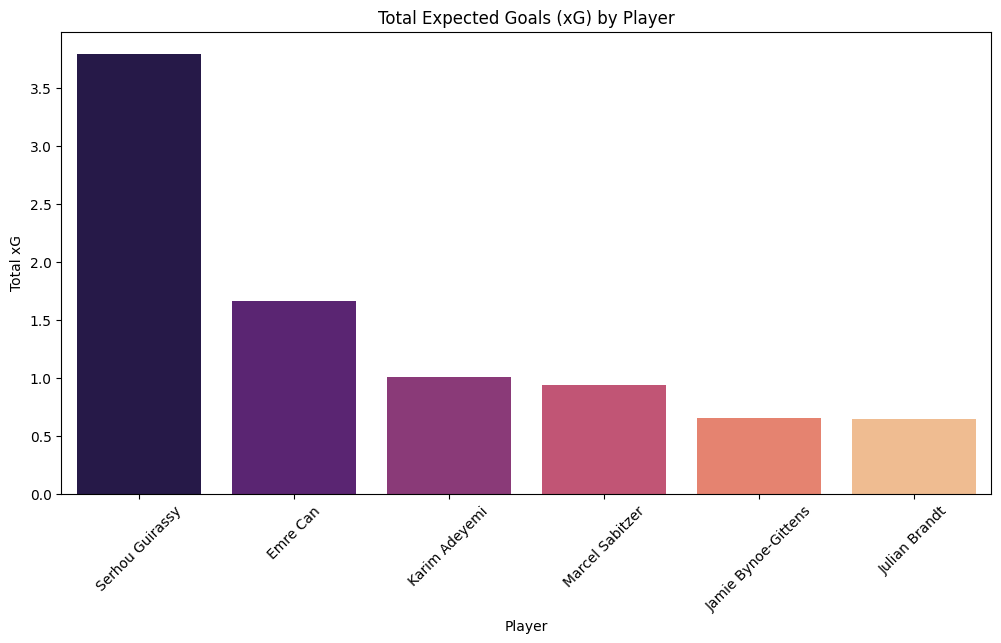

In [43]:
# Assuming you have a DataFrame called `xG_data`
xG_data = spark.sql("""
SELECT player, SUM(xG) AS total_xG
FROM player_stats
GROUP BY player
ORDER BY total_xG DESC
LIMIT 6
""").toPandas()

# Bar plot for total expected goals (xG)
plt.figure(figsize=(12, 6))
sns.barplot(data=xG_data, x='player', y='total_xG', palette='magma')
plt.title('Total Expected Goals (xG) by Player')
plt.xlabel('Player')
plt.ylabel('Total xG')
plt.xticks(rotation=45)
plt.show()
